In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Downloading the datasets

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yngvilskomedal","key":"dda46b3019295c90f6cacd3c8101678d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140
!kaggle datasets download -d fifthtribe/how-isis-uses-twitter

 91% 74.0M/80.9M [00:00<00:00, 193MB/s]
100% 80.9M/80.9M [00:00<00:00, 168MB/s]
  0% 0.00/2.37M [00:00<?, ?B/s]
100% 2.37M/2.37M [00:00<00:00, 92.0MB/s]


In [ ]:
! mkdir datasets

In [ ]:
!unzip sentiment140.zip -d /content/datasets
!unzip how-isis-uses-twitter.zip -d /content/datasets

Archive:  sentiment140.zip
  inflating: /content/datasets/training.1600000.processed.noemoticon.csv  
Archive:  how-isis-uses-twitter.zip
  inflating: /content/datasets/tweets.csv  
  inflating: /content/datasets/tweets.xlsx  


# Initializing variables

In [ ]:
# Dataset
NEUTRAL_DATASET_PATH = '/content/datasets/training.1600000.processed.noemoticon.csv'
RADICAL_DATASET_PATH =  '/content/datasets/tweets.csv'
TRAIN_SIZE = 0.8

# Text Cleaning
stemmer = PorterStemmer()


# Loading the data and data preprocessing

In [ ]:
df_radical = pd.read_csv(RADICAL_DATASET_PATH)

In [ ]:
# Keep only the column containing the tweets
df_radical = df_radical.filter(['tweets'], axis=1)
df_radical['is_radical'] = 1

In [ ]:
df_radical.head()

,tweets,is_radical
0,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...,1
1,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...,1
2,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...,1
3,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...,1
4,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...,1


In [ ]:
df_non_radical = pd.read_csv(NEUTRAL_DATASET_PATH, encoding='ISO-8859-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])

In [ ]:
# How many tweets are annotated negative (0) and positive (4)
df_non_radical.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [ ]:
# Create a neutral data set containing 50/50 positive and negative tweets
negative_tweets = df_non_radical[df_non_radical['target'] == 0].sample(75000)

positive_tweets = df_non_radical[df_non_radical['target'] == 4].sample(75000)

df_neutral = pd.concat([negative_tweets, positive_tweets])

# Keep only the column containing the tweets
df_neutral = df_neutral.filter(['text'], axis=1)

# Rename 'text' column to 'tweets'
df_neutral.rename(columns={'text': 'tweets'}, inplace=True)
df_neutral['is_radical'] = 0

In [ ]:
df_neutral.head()

,tweets,is_radical
564351,It has probably been more than a year since I ...,0
669946,http://bit.ly/11scsc nem to acreditando !! ...,0
323110,right gettin ready 4 studio bt i cant stand th...,0
155620,needs a hug,0
45562,"@khaled white mb battery, online or from Jed? ...",0


In [ ]:
def preprocess(tweet):
    # Many tweets from radical dataset starts with 'ENGLISHT RANSLATION:', remove this
    tweet = re.sub(r'ENGLISH TRANSLATION:','', tweet)

    # Remove link, user and special characters
    tweet = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', str(tweet).lower()).strip()
    tokens = []

    # Remove stopwords and stem words
    for token in tweet.split():
        if token and token not in stopwords.words("english"):
              tokens.append(stemmer.stem(token))
    return " ".join(tokens)

In [ ]:
# Preprocess the column containing the tweets
df_radical['tweets'] = df_radical['tweets'].apply(preprocess)
df_neutral['tweets'] = df_neutral['tweets'].apply(preprocess)

# Combine the datasets
df_all_tweets = pd.concat([df_radical, df_neutral])

In [ ]:
df_all_tweets.head()

,tweets,is_radical
0,messag truth syria sheikh abu muham al maqdisi,1
1,sheikh fatih al jawlani peopl integr sacrific ...,1
2,first audio meet sheikh fatih al jawlani ha,1
3,sheikh nasir al wuhayshi ha leader aqap promis...,1
4,aqap respons sheikh baghdadi statement althoug...,1


## Splitting of Data
The neutral and radical datasets are merged. For training and testing the model, the dataset needs to be divided into training and testing.
The train_test _split method divides the data randomly by shuffling the data before dividing the dataset. The shuffling is controlled by the parameter called random state.

75% of the data was used to train the model and the remaining 25% for training.

In [ ]:
train_data, test_data = train_test_split(df_all_tweets, test_size=0.25, random_state=42)

# Creating Word2Vec features

## Initialize the model
Building a Word2Vec using CBOW, and not skip grams. The variables (and choice of CBOW instead of skip grams) are based on Løvås (2022) master thesis *Recognizing Social Media Right-Wing Radicalization*, due to her building a Word2Vec on similar data

In [ ]:
w2v_model = Word2Vec(vector_size=50, window=5, min_count=7, workers=4)

### Building the vocabulary
This is a list of all the unique words in the training dataset.

In [ ]:
# Preprocess the tweets so they are on the right format
documents = train_data['tweets'].apply(gensim.utils.simple_preprocess)

In [ ]:
# Build the vocabulary
w2v_model.build_vocab(documents)

In [ ]:
vocabulary = w2v_model.wv.index_to_key
print("Vocab size", len(vocabulary))

Vocab size 8632


## Training the model

In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=200)

(153694724, 181639000)

In [ ]:
# Save the model
w2v_model.save('w2v.model')

## Testing the word embedddings using common examples

In [ ]:
w2v_model.wv.most_similar("love")

[('amaz', 0.8080103993415833),
 ('joe', 0.6082406044006348),
 ('awesom', 0.6058202385902405),
 ('lt', 0.5930392146110535),
 ('youu', 0.5735889673233032),
 ('cute', 0.565858781337738),
 ('fave', 0.557339072227478),
 ('listen', 0.5563586354255676),
 ('ador', 0.5506844520568848),
 ('beauti', 0.5321146845817566)]

In [ ]:
w2v_model.wv.most_similar("hate")

[('suck', 0.6669291257858276),
 ('urgh', 0.583250880241394),
 ('stupid', 0.5807167887687683),
 ('mean', 0.5346332788467407),
 ('ew', 0.5311275124549866),
 ('frustrat', 0.5203628540039062),
 ('ugh', 0.5183155536651611),
 ('ughh', 0.5126990675926208),
 ('ughhhh', 0.5101489424705505),
 ('annoy', 0.5035639405250549)]

In [ ]:
w2v_model.wv.most_similar("islam")

[('unit', 0.7061165571212769),
 ('disbeliev', 0.675429105758667),
 ('western', 0.62749844789505),
 ('arab', 0.6244881749153137),
 ('cleric', 0.6021163463592529),
 ('sharia', 0.595458447933197),
 ('isi', 0.5939327478408813),
 ('isil', 0.5726152658462524),
 ('ottoman', 0.5697242617607117),
 ('secular', 0.566383957862854)]

In [ ]:
vec = w2v_model.wv['king'] - w2v_model.wv['man'] + w2v_model.wv['woman']
w2v_model.wv.most_similar([vec])

[('king', 0.7970002889633179),
 ('hollywood', 0.5840782523155212),
 ('starship', 0.5125117301940918),
 ('woman', 0.504909098148346),
 ('terrorist', 0.4852336049079895),
 ('crusad', 0.4643128216266632),
 ('marin', 0.4606281518936157),
 ('bob', 0.45672500133514404),
 ('owner', 0.4549293518066406),
 ('crown', 0.45178279280662537)]

## Creating a word vector for each tweet
Converting the tweets to vectors by calculating the average word vector of all the words in the tweet. The average word vector is then assigned to the corresponding tweet.

The word vector represetning each tweet will be the input to the artificial neural network (ANN).

In [ ]:
def tweet_to_vector(tweet, model, vocabulary):
  # Adjust the size to the model's vector size
  vectorized_tweet = np.zeros(model.vector_size)

  # Convert the tweets to a vector of the words
  words = tweet.split()
  word_count = 0

  # Calculate how many words in the tweet are in the vocabulary
  for word in words:
    if word in vocabulary:
      vectorized_tweet += model.wv[word]
      word_count += 1

  # Calculate the average vector
  if word_count > 0:
    vectorized_tweet /= word_count

  return vectorized_tweet


Adding a column in the dataframe for the word vector of each tweet

In [ ]:
train_data['vectors'] = train_data['tweets'].apply(lambda tweet: tweet_to_vector(tweet, w2v_model, vocabulary))
test_data['vectors'] = test_data['tweets'].apply(lambda tweet: tweet_to_vector(tweet, w2v_model, vocabulary))

# Create BoW features

In [ ]:
# Create a Bag of Words model, that transform a text corpus to a matrix of counts
bow_vectorizer = CountVectorizer(max_features=1000)

# Fit the vectorizer on the training data
bow_vectorizer.fit(train_data['tweets'])

# Transform training and test data into BoW vectors
X_train_bow = bow_vectorizer.transform(train_data['tweets']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['tweets']).toarray()


# ANN Model training and evaluation

Train and evluate an ANN model to classify the vectorized tweets

In [ ]:
# Prepare the final input features for the neural network
X_train_w2v = np.vstack(train_data['vectors'].values)
X_test_w2v = np.vstack(test_data['vectors'].values)
y_train = train_data['is_radical'].values
y_test = test_data['is_radical'].values

## Building the ANN models, one with Word2Vec as input, the other with BoW

The parameters are based on the best performing model in Løvås' (2022) master thesis *Recognizing Social Media Right-Wing Radicalization*, due to her building a ANN on similar data

Parameters:
- Activation functions: ReLu for all layers except for the output layer where Softmax was used.
- Optimizer: Adam, løvås tried both Adam and SGD, the model using Adam had the least false positives (neutral posts classified as radical)
- Loss: Sparse Categorical Crossentropy
- Learning Rate: ExponentialDecay, increases the learning ratee durting training
- The dropout Rate is set to 0.5

In [ ]:
# Define the model architecture, with word2vec as input
nn_model_w2v = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_w2v.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Define the learning rate schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.96

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# Building the model
nn_model_w2v.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define the model architecture, with BoW as input
nn_model_bow = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_bow.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Building the model
nn_model_bow.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model, epochs is set to 15, however Løvås userd 150.
# Since the accuracy is pretty stable for all the epochs,
# it was decided that 15 was enough for this 'small' project
history_w2v = nn_model_w2v.fit(
    X_train_w2v,
    y_train,
    epochs=15,
    validation_data=(X_test_w2v, y_test)
)

Epoch 1/15
3924/3924 [==============================] - 13s 3ms/step - loss: 0.0818 - accuracy: 0.9752 - val_loss: 0.0667 - val_accuracy: 0.9801
Epoch 2/15
3924/3924 [==============================] - 14s 4ms/step - loss: 0.0807 - accuracy: 0.9758 - val_loss: 0.0666 - val_accuracy: 0.9800
Epoch 3/15
3924/3924 [==============================] - 14s 4ms/step - loss: 0.0801 - accuracy: 0.9757 - val_loss: 0.0668 - val_accuracy: 0.9802
Epoch 4/15
3924/3924 [==============================] - 15s 4ms/step - loss: 0.0818 - accuracy: 0.9757 - val_loss: 0.0667 - val_accuracy: 0.9801
Epoch 5/15
3924/3924 [==============================] - 13s 3ms/step - loss: 0.0806 - accuracy: 0.9757 - val_loss: 0.0668 - val_accuracy: 0.9802
Epoch 6/15
3924/3924 [==============================] - 14s 4ms/step - loss: 0.0806 - accuracy: 0.9759 - val_loss: 0.0667 - val_accuracy: 0.9801
Epoch 7/15
3924/3924 [==============================] - 14s 4ms/step - loss: 0.0805 - accuracy: 0.9750 - val_loss: 0.0667 - val_ac

In [ ]:
history_bow = nn_model_bow.fit(
    X_train_bow,
    y_train,
    epochs=15,
    validation_data=(X_test_bow, y_test)
)

Epoch 1/15
3924/3924 [==============================] - 17s 4ms/step - loss: 0.1463 - accuracy: 0.9538 - val_loss: 0.0916 - val_accuracy: 0.9718
Epoch 2/15
3924/3924 [==============================] - 14s 4ms/step - loss: 0.1048 - accuracy: 0.9672 - val_loss: 0.0905 - val_accuracy: 0.9722
Epoch 3/15
3924/3924 [==============================] - 15s 4ms/step - loss: 0.0980 - accuracy: 0.9682 - val_loss: 0.0901 - val_accuracy: 0.9721
Epoch 4/15
3924/3924 [==============================] - 14s 4ms/step - loss: 0.0963 - accuracy: 0.9683 - val_loss: 0.0907 - val_accuracy: 0.9721
Epoch 5/15
3924/3924 [==============================] - 17s 4ms/step - loss: 0.0951 - accuracy: 0.9686 - val_loss: 0.0906 - val_accuracy: 0.9721
Epoch 6/15
3924/3924 [==============================] - 16s 4ms/step - loss: 0.0927 - accuracy: 0.9694 - val_loss: 0.0911 - val_accuracy: 0.9722
Epoch 7/15
3924/3924 [==============================] - 15s 4ms/step - loss: 0.0920 - accuracy: 0.9698 - val_loss: 0.0914 - val_ac

In [ ]:
# Evaluate the ANN with Word2Vec model
test_loss_w2v, test_accuracy_w2v = nn_model_w2v.evaluate(X_test_w2v, y_test, verbose=2)
print("ANN with Word2Vec")
print(f"Test accuracy: {test_accuracy_w2v}")
print(f"Test loss: {test_loss_w2v}")

# Evaluate the ANN with BoW model
test_loss_bow, test_accuracy_bow = nn_model_bow.evaluate(X_test_bow, y_test, verbose=2)
print("ANN with BoW")
print(f"Test accuracy: {test_accuracy_bow}")
print(f"Test loss: {test_loss_bow}")

1308/1308 - 3s - loss: 0.0668 - accuracy: 0.9801 - 3s/epoch - 2ms/step
ANN with Word2Vec
Test accuracy: 0.9800969958305359
Test loss: 0.06676305085420609
1308/1308 - 2s - loss: 0.0928 - accuracy: 0.9726 - 2s/epoch - 2ms/step
ANN with BoW
Test accuracy: 0.9726423621177673
Test loss: 0.09275990724563599


In [ ]:
nn_model_w2v.summary()
nn_model_bow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 2194 (8.57 KB)
Trainable params: 2194 (8.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
__

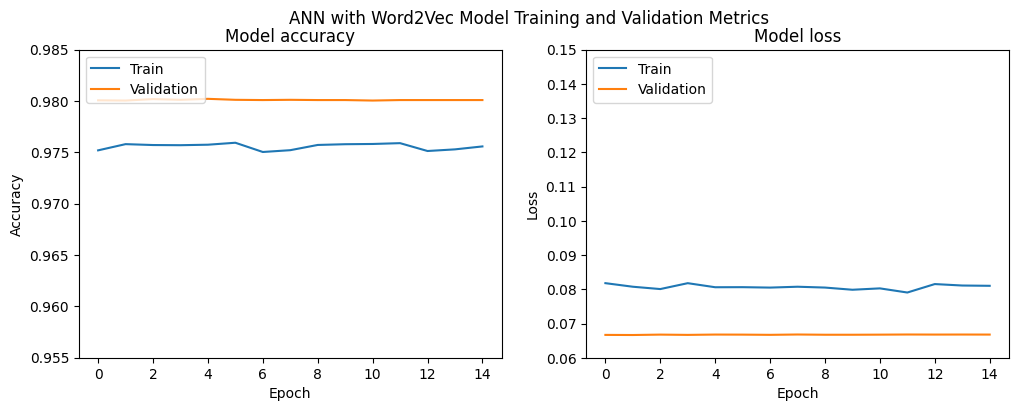

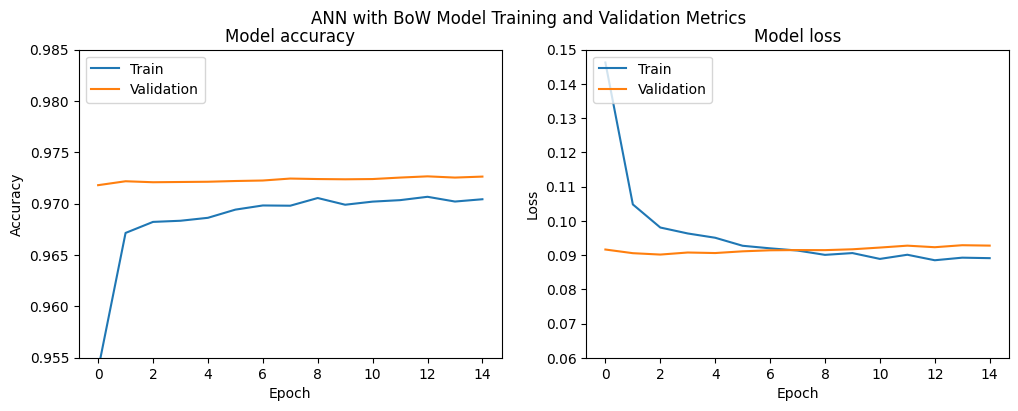

In [ ]:
# Plot training & validation accuracy values

accuracy_ylim = (0.955, 0.985)
loss_ylim = (0.06, 0.15)

plt.figure(figsize=(12, 4))
plt.suptitle('ANN with Word2Vec Model Training and Validation Metrics')
plt.subplot(1, 2, 1)
plt.plot(history_w2v.history['accuracy'])
plt.plot(history_w2v.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(accuracy_ylim)
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_w2v.history['loss'])
plt.plot(history_w2v.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim(loss_ylim)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

plt.figure(figsize=(12, 4))
plt.suptitle('ANN with BoW Model Training and Validation Metrics')
plt.subplot(1, 2, 1)
plt.plot(history_bow.history['accuracy'])
plt.plot(history_bow.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(accuracy_ylim)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_bow.history['loss'])
plt.plot(history_bow.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim(loss_ylim)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1308/1308 [==============================] - 2s 2ms/step


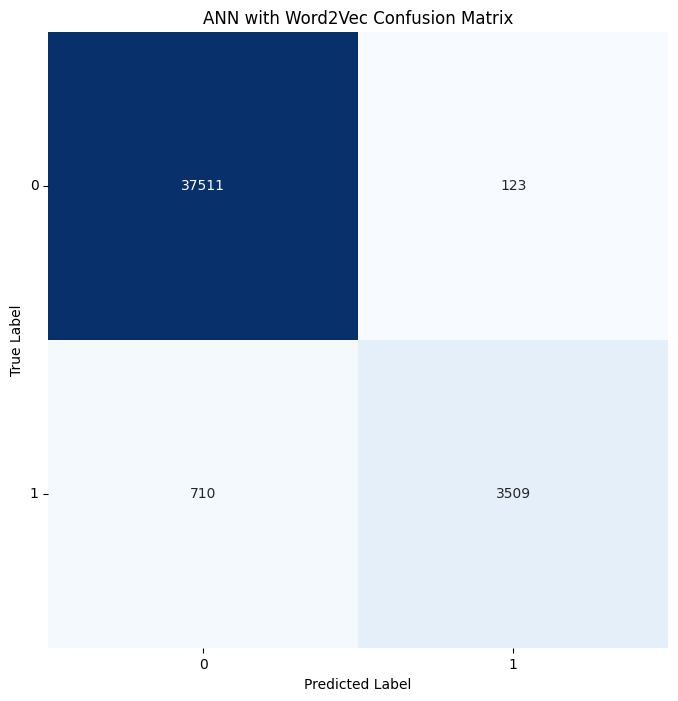

1308/1308 [==============================] - 4s 3ms/step


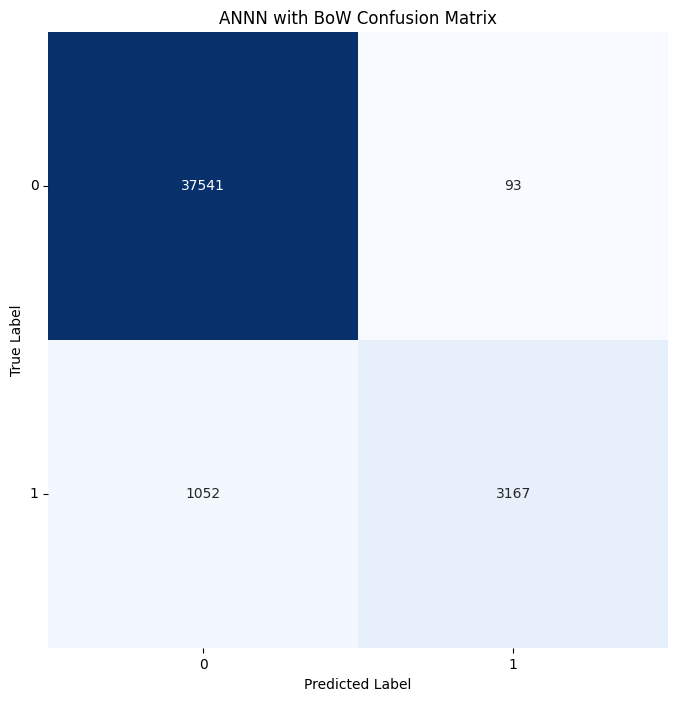

In [ ]:
# Create Confusin Matrix for the W2V model
predictions_w2v = nn_model_w2v.predict(X_test_w2v)
predicted_classes_w2v = np.argmax(predictions_w2v, axis=1)

# Generate the confusion matrix
cm_w2v = confusion_matrix(y_test, predicted_classes_w2v)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_w2v, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", ylabel="True Label", title="ANN with Word2Vec Confusion Matrix")
plt.yticks(rotation=0)

plt.show()

# Create Confusion Matrix for the BoW model
predictions_bow = nn_model_bow.predict(X_test_bow)
predicted_classes_bow = np.argmax(predictions_bow, axis=1)

cm_bow = confusion_matrix(y_test, predicted_classes_bow)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_bow, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", ylabel="True Label", title="ANNN with BoW Confusion Matrix")
plt.yticks(rotation=0)

plt.show()

In [ ]:
precision_w2v = precision_score(y_test, predicted_classes_w2v, average='binary')
recall_w2v = recall_score(y_test, predicted_classes_w2v, average='binary')
f1_w2v = f1_score(y_test, predicted_classes_w2v, average='binary')

print("ANN with Word2Vec:")
print(f"Precision: {precision_w2v}")
print(f"Recall: {recall_w2v}")
print(f"F1 Score: {f1_w2v}")

precision_bow = precision_score(y_test, predicted_classes_bow, average='binary')
recall_bow = recall_score(y_test, predicted_classes_bow, average='binary')
f1_bow = f1_score(y_test, predicted_classes_bow, average='binary')

print("ANN with BoW:")
print(f"Precision: {precision_bow}")
print(f"Recall: {recall_bow}")
print(f"F1 Score: {f1_bow}")

ANN with Word2Vec:
Precision: 0.9661343612334802
Recall: 0.831713676226594
F1 Score: 0.8938988663864474
ANN with BoW:
Precision: 0.9714723926380369
Recall: 0.7506518132258829
F1 Score: 0.8469046663992513


# Baseline Classifier
For sammenligningsgrunnlag. Dersom modellen vår slår denne, så har vi en "god" modell. Denne tar fordleingen i datasettet som utgangspunkt, og randomly predicter ut fra denne fordelingen.

In [ ]:
baseline_model = DummyClassifier(strategy='stratified', random_state=42)

baseline_model.fit(X_train_w2v, y_train)

baseline_predictions = baseline_model.predict(X_test_w2v)


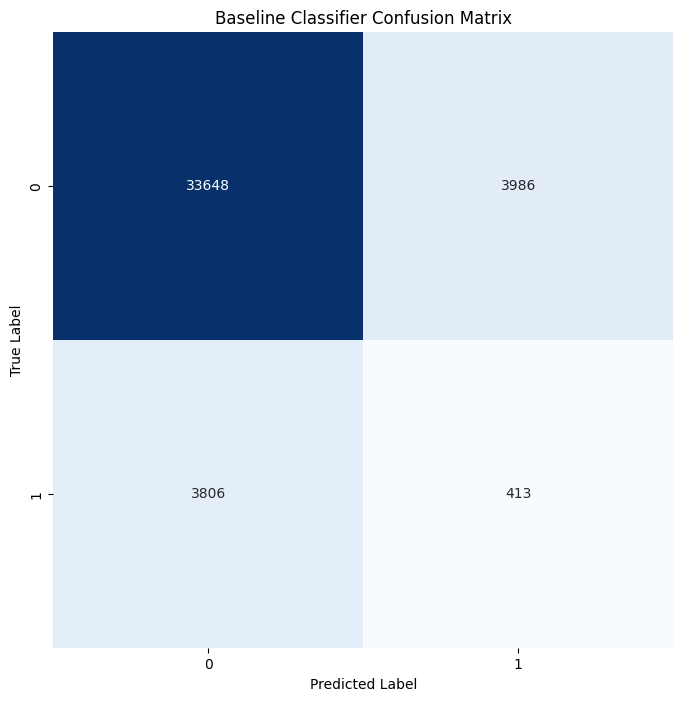

In [ ]:
cm_baseline = confusion_matrix(y_test, baseline_predictions)

plt.figure(figsize=(8, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title('Baseline Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print(f"Baseline Classifier Accuracy: {baseline_accuracy:.2f}")

baseline_precision = precision_score(y_test, baseline_predictions, average='binary')
baseline_recall = recall_score(y_test, baseline_predictions, average='binary')
baseline_f1 = f1_score(y_test, baseline_predictions, average='binary')

print("Baseline:")
print(f"Precision: {baseline_precision}")
print(f"Recall: {baseline_recall}")
print(f"F1 Score: {baseline_f1}")

Baseline Classifier Accuracy: 0.81
Baseline:
Precision: 0.09388497385769493
Recall: 0.09789049537805167
F1 Score: 0.09584590392202366
